In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table
import csv
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import emcee
import corner

In [2]:
data = Table.read("pleiadi_817", format= "ascii" )

In [3]:
data

<Table length=817>
   _RAJ2000   ...
   float64    ...
------------- ...
45.8693844394 ...
46.1480336919 ...
46.3612008002 ...
 46.376163428 ...
46.3784538692 ...
46.3967887284 ...
46.4208878955 ...
46.4499147713 ...
46.6362510351 ...
46.7186370503 ...
          ... ...
 66.577073247 ...
66.7616424434 ...
66.7807862636 ...
66.8226972274 ...
66.8918776608 ...
66.9705540999 ...
67.0032629918 ...
67.0506465777 ...
67.0841077824 ...
67.1659583004 ...

In [4]:
pmRA = data["pmRA"]
pmDE = data["pmDE"]
RA = data["RArad"]
DE = data["DErad"]
Plx = data["Plx"]
e_plx = data["e_Plx"]

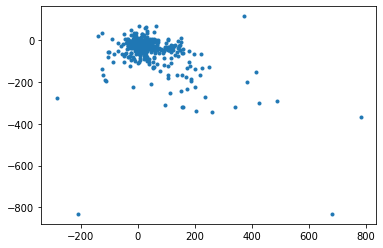

In [5]:
plt.plot(pmRA, pmDE, '.')

(-60.0, 20.0)

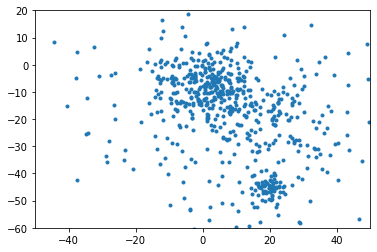

In [6]:
plt.plot(pmRA, pmDE, '.')
plt.xlim(-50,50)
plt.ylim(-60,20)

In [7]:
def sum_err(e_plx, sigma_cl):
    return sigma_cl**2 + e_plx**2

def loglikelihood(par, Plx, e_plx):
    Pcl, sigma_cl = par
    err = sum_err(e_plx, sigma_cl)
    return -0.5 * np.sum(np.log(2*np.pi) + np.log(err) + (Plx - Pcl)**2/((err)))

In [8]:
Pcl_min = 0
Pcl_max = 20
sigma_cl_min = 0.1
sigma_cl_max = 5

def logprior(par):
    Pcl, sigma_cl = par
    if Pcl < Pcl_min or Pcl > Pcl_max or sigma_cl < sigma_cl_min or sigma_cl > sigma_cl_max:
        return -np.inf
    else:
        return -np.log((Pcl_max - Pcl_min)*(sigma_cl_max - sigma_cl_min))

In [9]:
def logposterior(par, Plx, e_plx):
    lp = logprior(par)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + loglikelihood(par, Plx, e_plx)

In [10]:
Y = np.zeros((len(pmRA), 2))

for i in range(len(pmRA)):
    Y[i,0] = pmRA[i]
    Y[i,1] = pmDE[i]

In [11]:
Y;

In [12]:
gm = GaussianMixture(n_components=5, random_state=0, n_init=100, 
                     init_params="random", covariance_type = 'spherical').fit(Y)

In [13]:
gm.means_

array([[   1.41812878,   -7.80641928],
       [  19.82929007,  -45.34312609],
       [  12.8360411 ,  -20.65798795],
       [ 182.35166977, -234.79154097],
       [  48.38936955,  -46.47546817]])

In [14]:
labels = gm.predict(Y)

(-100.0, 100.0)

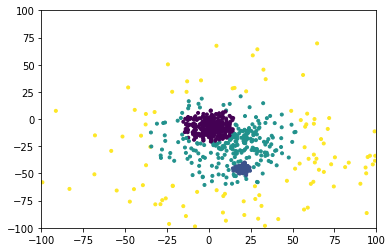

In [15]:
plt.scatter(Y[:,0], Y[:,1], c = labels, marker = '.')
plt.xlim(-100,100)
plt.ylim(-100,100)

In [16]:
gm.predict_proba(Y)

array([[1.30650739e-049, 0.00000000e+000, 5.97505725e-006,
        1.61265847e-002, 9.83867440e-001],
       [7.40914215e-001, 7.26255131e-091, 2.30662529e-001,
        3.07554480e-004, 2.81157011e-002],
       [8.93707990e-001, 1.70132644e-056, 1.00533443e-001,
        5.30487436e-005, 5.70551741e-003],
       ...,
       [8.66220722e-001, 2.79532943e-051, 1.26732024e-001,
        6.47284502e-005, 6.98252549e-003],
       [5.10516313e-001, 1.76457098e-031, 4.67541959e-001,
        1.84379852e-004, 2.17573483e-002],
       [5.90995714e-027, 5.54962680e-112, 1.91956234e-002,
        9.17750516e-003, 9.71626871e-001]])

In [17]:
data['prob'] = gm.predict_proba(Y)

In [18]:
data

<Table length=817>
   _RAJ2000      _DEJ2000   ...                    prob [5]                  
   float64       float64    ...                    float64                   
------------- ------------- ... ---------------------------------------------
45.8693844394 23.0614762283 ...  1.3065073907892236e-49 .. 0.9838674402050294
46.1480336919 21.7239808543 ...    0.7409142153539164 .. 0.028115701090238792
46.3612008002 25.2551737877 ...     0.8937079904929592 .. 0.00570551740602944
 46.376163428 20.9023756143 ... 0.00021051616629661662 .. 0.07512285197619033
46.3784538692 25.8688664167 ...    0.8707301896567234 .. 0.007466121139097968
46.3967887284 27.8696249784 ...    0.6774552490383381 .. 0.016046199113292883
46.4208878955 23.0940457143 ...     0.7733155267749121 .. 0.02475270603569953
46.4499147713 27.6864382603 ...  4.7659104899891345e-27 .. 0.9624672687165751
46.6362510351 24.2214026139 ...    0.8546580693736929 .. 0.014873583905469308
46.7186370503 20.8619829805 ... 2.2762233278260495e-05 .. 0.09087211515313899
          ...           ... ...                                           ...
 66.577073247 21.4704292239 ...   3.3803524287852328e-49 .. 0.986554405728757
66.7616424434 25.7062209934 ...    0.2913761636188371 .. 0.031869333283804376
66.7807862636 20.9908852675 ... 3.1851885705788575e-08 .. 0.19671998233833018
66.8226972274 22.9963336735 ...    0.8395092073825615 .. 0.008487240948842859
66.8918776608  25.061587429 ...    0.8991993233357026 .. 0.005806321232393887
66.9705540999 24.4447899477 ...                 0.0 .. 5.7945315070385334e-06
67.0032629918 21.6199044508 ...  3.0504105546039507e-46 .. 0.9872992488062423
67.0506465777 22.3327665696 ...    0.8662207217476492 .. 0.006982525485717174
67.0841077824 24.1178186832 ...     0.5105163132584289 .. 0.02175734834542877
67.1659583004 26.2200815532 ...  5.9099571427706896e-27 .. 0.9716268714931225

In [19]:
#metodo 1 per tagliare i dati
prob = data['prob']
p = prob[:,1]
mask = [(p > 0.05)]

Plxs= Plx[tuple(mask)]
e_plxs = e_plx[tuple(mask)]

In [20]:
len(Plxs)

78

In [21]:
Plxs;

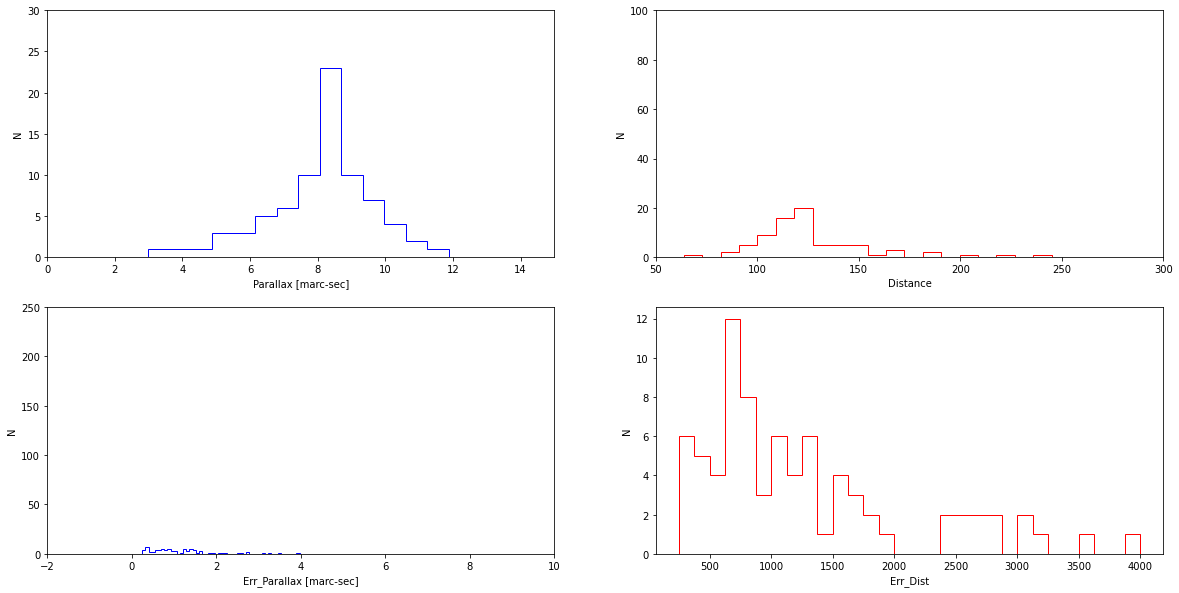

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(20,10));
axs[0,0].hist(Plxs, bins = 20, histtype='step', color = 'blue');
axs[0,0].set_xlim(0, 15)
axs[0,0].set_ylim(0, 30)
axs[0,0].set_xlabel("Parallax [marc-sec]")
axs[0,0].set_ylabel("N");
axs[0,1].hist(1000/Plxs, bins = 30, histtype='step', color = 'red');
axs[0,1].set_xlim(50, 300)
axs[0,1].set_ylim(0, 100)
axs[0,1].set_xlabel("Distance")
axs[0,1].set_ylabel("N");
axs[1,0].hist(e_plxs, bins = 50, histtype='step', color = 'blue');
axs[1,0].set_xlim(-2, 10)
axs[1,0].set_ylim(0, 250)
axs[1,0].set_xlabel("Err_Parallax [marc-sec]")
axs[1,0].set_ylabel("N");
axs[1,1].hist(1000/e_plxs, bins = 30, histtype='step', color = 'red');
axs[1,1].set_xlabel("Err_Dist")
axs[1,1].set_ylabel("N");

(-60.0, -30.0)

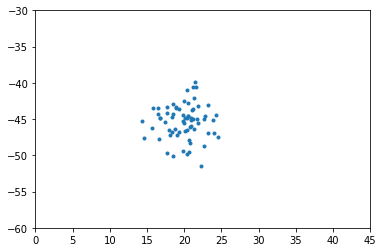

In [23]:
#metodo 2 per tagliare i dati
ppmDE = []
ppmRA = []
pDE = []
pRA = []
pPlx = []
pe_plx = []

for i in range(len(labels)):
    if (labels[i] == 1):
        ppmDE.append(pmDE[i])
        ppmRA.append(pmRA[i])
        pDE.append(DE[i])
        pRA.append(RA[i])
        pPlx.append(Plx[i])
        pe_plx.append(e_plx[i])
        
fig, ax = plt.subplots()
ax.plot(ppmRA, ppmDE, '.')
ax.set_xlim(0,45)
ax.set_ylim(-60,-30)

In [24]:
sigma_cl = gm.covariances_[1]
print(sigma_cl)

6.0794516207080305


In [25]:
pPlx_ = np.array(pPlx)
pe_plx_ = np.array(pe_plx)

In [26]:
soln = [np.random.uniform (Pcl_min, Pcl_max), np.random.uniform(sigma_cl_min, sigma_cl_max)]

pos = soln + 1e-4 * np.random.randn(15, 2)
nwalkers, ndim = pos.shape

#for i in range(len(pPlx_)):
    #sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior, args=(pPlx_[i], pe_plx_[i]))
sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior, args=(pPlx_, pe_plx_))

sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:03<00:00, 1279.30it/s]


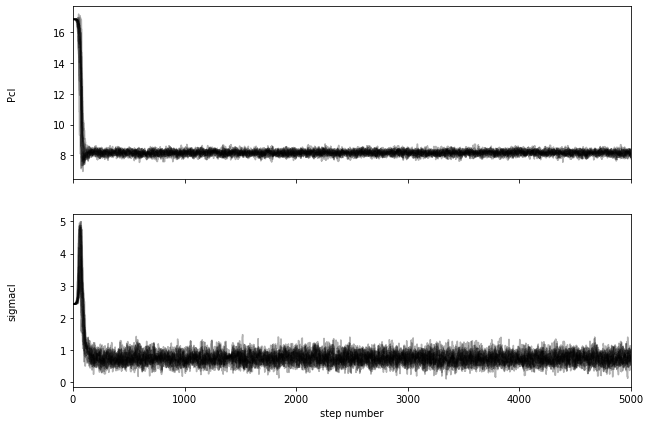

In [27]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Pcl", "sigmacl"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [28]:
samples[4999,3,0], samples[4999,3,1]

(8.068162394147317, 0.8578197781940454)

In [31]:
flat_samples = sampler.get_chain(discard=100, thin=1, flat=True)
print(flat_samples.shape)

(73500, 2)


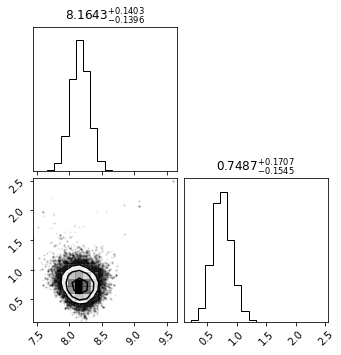

In [32]:
fig = corner.corner(
    flat_samples,
    show_titles=True,
    title_fmt='.4f'
);
plt.savefig("posterior_2.pdf")

In [38]:
y = flat_samples[:,0]
x = 

122.42599348693714